In [6]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import os

In [7]:
np.random.seed(111)

In [8]:
# Loading file paths
root_path = os.getcwd()

train_path = os.path.join(root_path, 'data', 'train_FD00X.txt')
test_path = os.path.join(root_path, 'data', 'test_FD00X.txt')
RUL_path = os.path.join(root_path, 'data', 'RUL_FD00X.txt')

labels = ['unit', 'cycles', 'opMode1', 'opMode2', 'opMode3'] + [f'sensor{i}' for i in range(1, 22)]  # column headers, see readme file

In [9]:
# Function to load data and drop the columns specified by cols_to_drop, and add an RUL column for each unit
def load_data(filepath, rul=False):
    data = []
    # Creating lists which hold dataframes for each test trajectory
    if not rul:
        for i in range(1, 5):
            data.append(pd.read_csv(filepath.replace('X', str(i)),
                                    names=labels, delimiter='\s+',
                                    ))
        return data
    else:
        for i in range(1, 5):
            data.append(pd.read_csv(filepath.replace('X', str(i)),
                                    delimiter='\s+', header=None,
                                    ))

        return data  # a list


def prepare_data(train_data: pd.DataFrame):
    # Adds an RUL column for training
    ### TRAINING DATAFRAMES ###

    rul = pd.DataFrame(train_data.groupby('unit')['cycles'].max()).reset_index()
    rul.columns = ['unit', 'max']

    train_data = train_data.merge(rul, on=['unit'], how='left')

    train_data['RUL'] = train_data['max'] - train_data['cycles']
    train_data.drop('max', axis=1, inplace=True)

    return train_data

In [10]:
# Initialising data
train_data, test_data, RUL_data = load_data(train_path), load_data(test_path), load_data(RUL_path, True)

In [11]:
# Adding RUL columns 
for i in range(len(train_data)):
    train_data[i] = prepare_data(train_data[i])

In [12]:
train_data[0]

unit  cycles  opMode1  opMode2  opMode3  sensor1  sensor2  sensor3  \
0         1       1  -0.0007  -0.0004    100.0   518.67   641.82  1589.70   
1         1       2   0.0019  -0.0003    100.0   518.67   642.15  1591.82   
2         1       3  -0.0043   0.0003    100.0   518.67   642.35  1587.99   
3         1       4   0.0007   0.0000    100.0   518.67   642.35  1582.79   
4         1       5  -0.0019  -0.0002    100.0   518.67   642.37  1582.85   
...     ...     ...      ...      ...      ...      ...      ...      ...   
20626   100     196  -0.0004  -0.0003    100.0   518.67   643.49  1597.98   
20627   100     197  -0.0016  -0.0005    100.0   518.67   643.54  1604.50   
20628   100     198   0.0004   0.0000    100.0   518.67   643.42  1602.46   
20629   100     199  -0.0011   0.0003    100.0   518.67   643.23  1605.26   
20630   100     200  -0.0032  -0.0005    100.0   518.67   643.85  1600.38   

       sensor4  sensor5  ...  sensor13  sensor14  sensor15  sensor16  \
0      1400.60    14.62  ...   2388.02   8138.62    8.4195      0.03   
1      1403.14    14.62  ...   2388.07   8131.49    8.4318      0.03   
2      1404.20    14.62  ...   2388.03   8133.23    8.4178      0.03   
3      1401.87    14.62  ...   2388.08   8133.83    8.3682      0.03   
4      1406.22    14.62  ...   2388.04   8133.80    8.4294      0.03   
...        ...      ...  ...       ...       ...       ...       ...   
20626  1428.63    14.62  ...   2388.26   8137.60    8.4956      0.03   
20627  1433.58    14.62  ...   2388.22   8136.50    8.5139      0.03   
20628  1428.18    14.62  ...   2388.24   8141.05    8.5646      0.03   
20629  1426.53    14.62  ...   2388.23   8139.29    8.5389      0.03   
20630  1432.14    14.62  ...   2388.26   8137.33    8.5036      0.03   

       sensor17  sensor18  sensor19  sensor20  sensor21  RUL  
0           392      2388     100.0     39.06   23.4190  191  
1           392      2388     100.0     39.00   23.4236  190  
2           390      2388     100.0     38.95   23.3442  189  
3           392      2388     100.0     38.88   23.3739  188  
4           393      2388     100.0     38.90   23.4044  187  
...         ...       ...       ...       ...       ...  ...  
20626       397      2388     100.0     38.49   22.9735    4  
20627       395      2388     100.0     38.30   23.1594    3  
20628       398      2388     100.0     38.44   22.9333    2  
20629       395      2388     100.0     38.29   23.0640    1  
20630       396      2388     100.0     38.37   23.0522    0  

[20631 rows x 27 columns]

In [13]:
train_data[0].describe()

unit        cycles       opMode1       opMode2  opMode3  \
count  20631.000000  20631.000000  20631.000000  20631.000000  20631.0   
mean      51.506568    108.807862     -0.000009      0.000002    100.0   
std       29.227633     68.880990      0.002187      0.000293      0.0   
min        1.000000      1.000000     -0.008700     -0.000600    100.0   
25%       26.000000     52.000000     -0.001500     -0.000200    100.0   
50%       52.000000    104.000000      0.000000      0.000000    100.0   
75%       77.000000    156.000000      0.001500      0.000300    100.0   
max      100.000000    362.000000      0.008700      0.000600    100.0   

        sensor1       sensor2       sensor3       sensor4       sensor5  ...  \
count  20631.00  20631.000000  20631.000000  20631.000000  2.063100e+04  ...   
mean     518.67    642.680934   1590.523119   1408.933782  1.462000e+01  ...   
std        0.00      0.500053      6.131150      9.000605  1.776400e-15  ...   
min      518.67    641.210000   1571.040000   1382.250000  1.462000e+01  ...   
25%      518.67    642.325000   1586.260000   1402.360000  1.462000e+01  ...   
50%      518.67    642.640000   1590.100000   1408.040000  1.462000e+01  ...   
75%      518.67    643.000000   1594.380000   1414.555000  1.462000e+01  ...   
max      518.67    644.530000   1616.910000   1441.490000  1.462000e+01  ...   

           sensor13      sensor14      sensor15      sensor16      sensor17  \
count  20631.000000  20631.000000  20631.000000  2.063100e+04  20631.000000   
mean    2388.096152   8143.752722      8.442146  3.000000e-02    393.210654   
std        0.071919     19.076176      0.037505  1.387812e-17      1.548763   
min     2387.880000   8099.940000      8.324900  3.000000e-02    388.000000   
25%     2388.040000   8133.245000      8.414900  3.000000e-02    392.000000   
50%     2388.090000   8140.540000      8.438900  3.000000e-02    393.000000   
75%     2388.140000   8148.310000      8.465600  3.000000e-02    394.000000   
max     2388.560000   8293.720000      8.584800  3.000000e-02    400.000000   

       sensor18  sensor19      sensor20      sensor21           RUL  
count   20631.0   20631.0  20631.000000  20631.000000  20631.000000  
mean     2388.0     100.0     38.816271     23.289705    107.807862  
std         0.0       0.0      0.180746      0.108251     68.880990  
min      2388.0     100.0     38.140000     22.894200      0.000000  
25%      2388.0     100.0     38.700000     23.221800     51.000000  
50%      2388.0     100.0     38.830000     23.297900    103.000000  
75%      2388.0     100.0     38.950000     23.366800    155.000000  
max      2388.0     100.0     39.430000     23.618400    361.000000  

[8 rows x 27 columns]

Columns with a very low standard deviation can be ignored as it shows the values are roughly constant. Constant values do not have much bearing on machine learning methods, especially here since we are dealing with time series data.

Additionally, we can observe generally the trend between the sensor readings and the RUL. Although the data is very noisy, the engines are all of the same make but only subject to different arbitrary conditions of wear and tear. We can go through a smaller subset of engine units, say 10 out of the 100. 


In [14]:
def plot_sensor_reading(df):
    # plotting sensors against RUL 
    cols_to_plot = [col for col in df.columns if col not in ['unit', 'cycles', 'RUL']]
    
    for col in cols_to_plot:
        plt.figure(figsize=(12, 4))
        for unit in df['unit'].unique()[:10]:  # plot for 10 units
            unit_data = df[df['unit'] == unit]
            plt.plot(unit_data['cycles'], unit_data[col], label=f'Unit {unit}', linewidth=0.9)
        plt.title(f'Sensor readings for {col}')
        plt.xlabel('Cycles')
        plt.ylabel(f'{col} reading')
        plt.legend()
        plt.show()
    
    return None

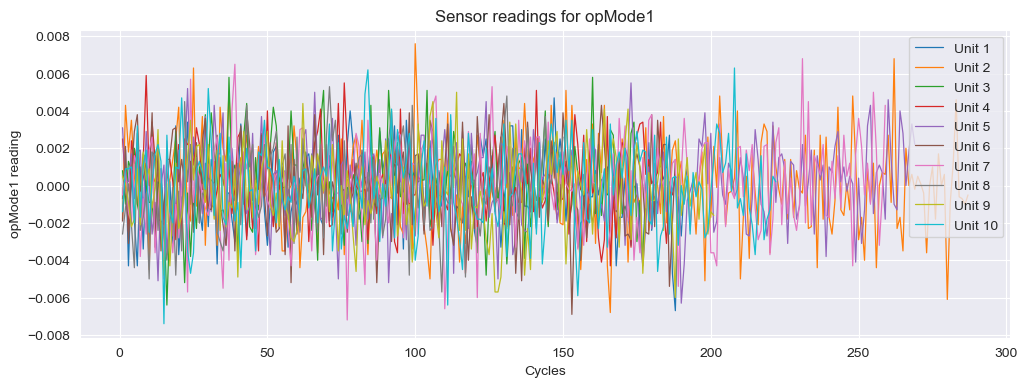

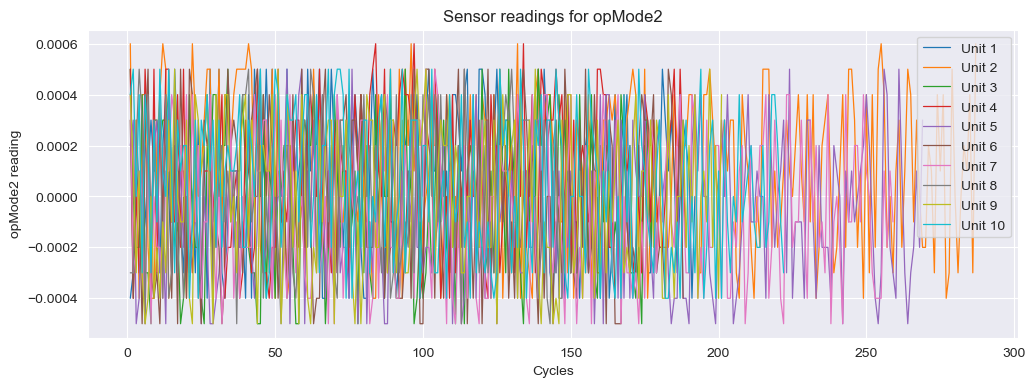

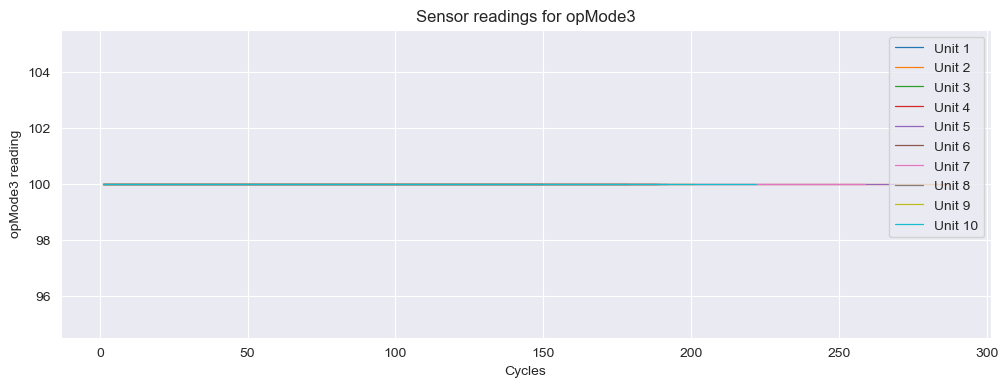

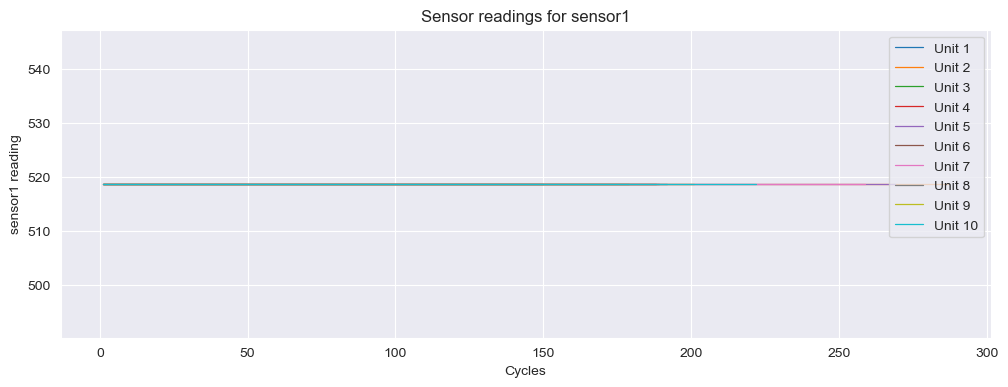

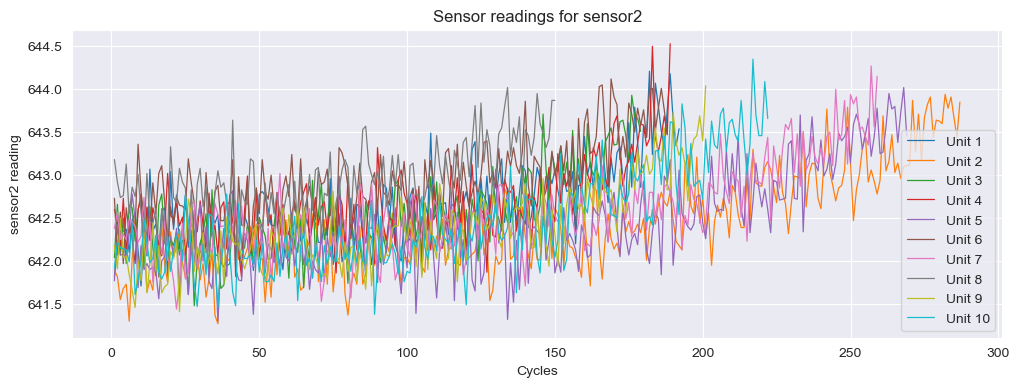

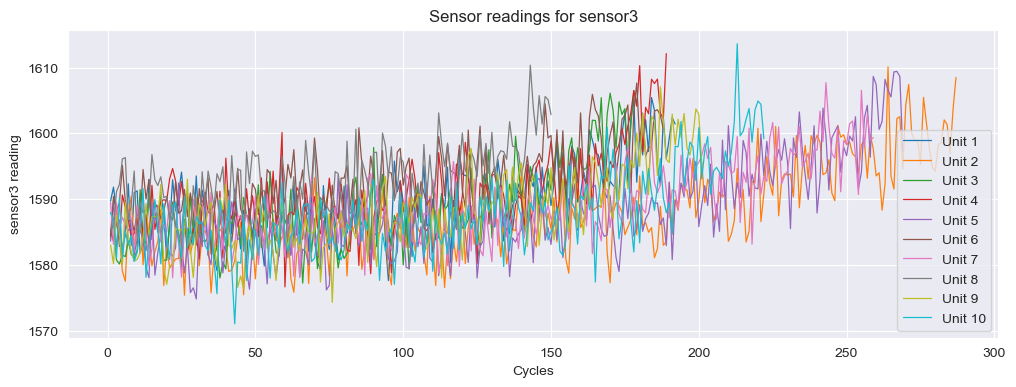

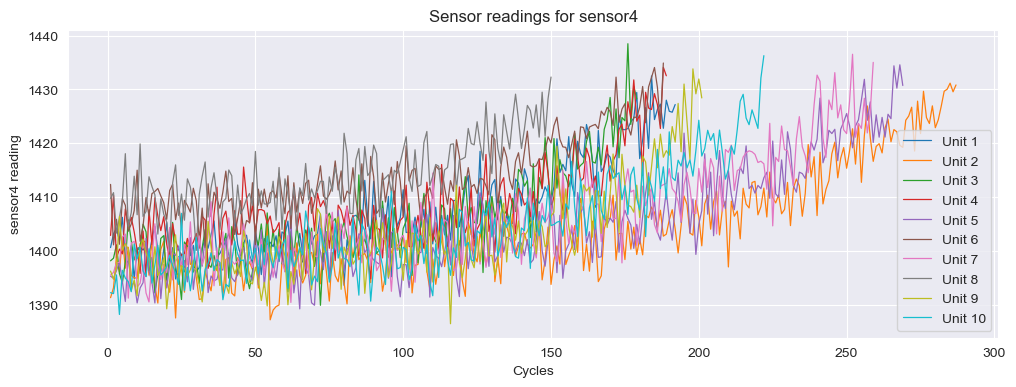

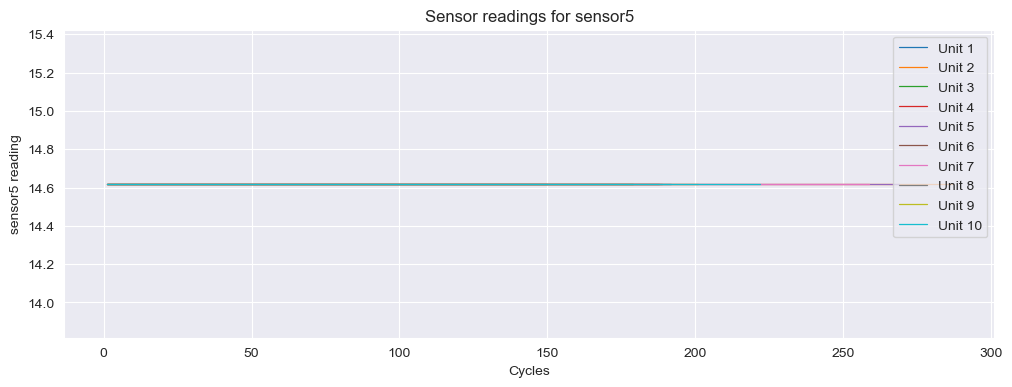

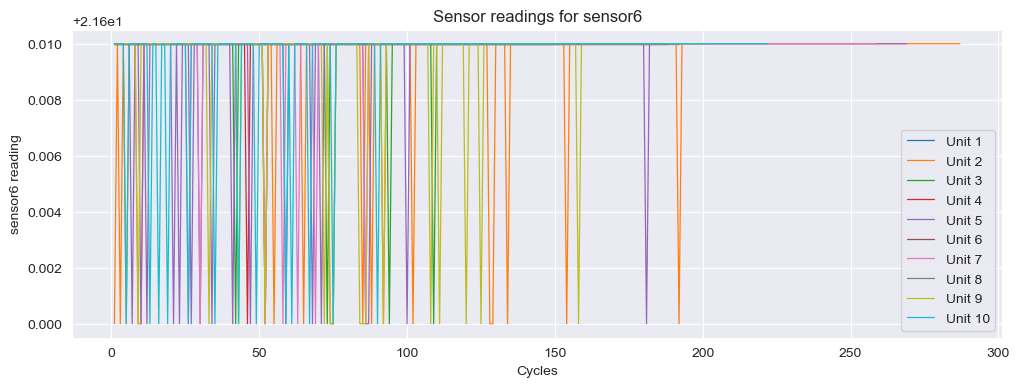

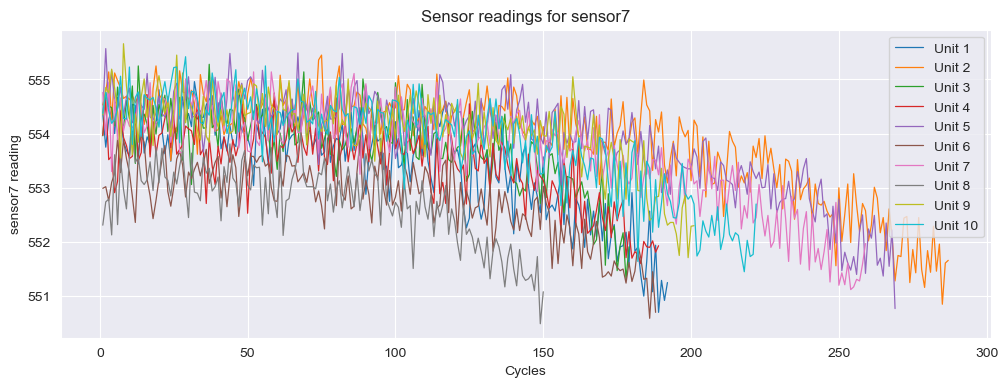

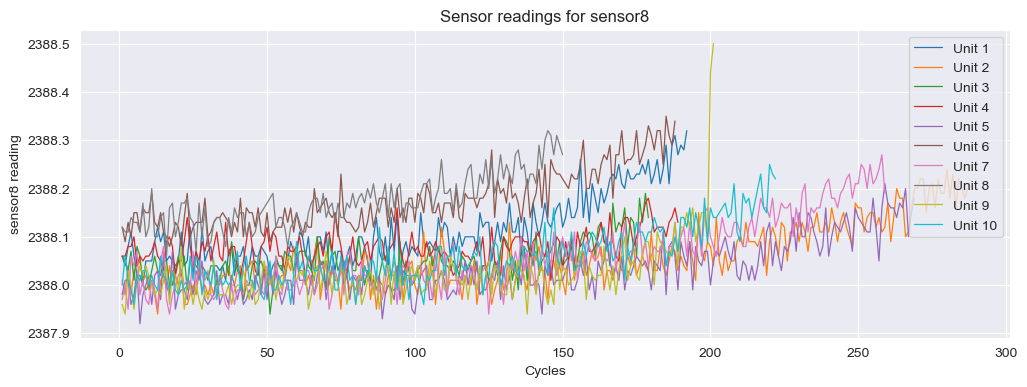

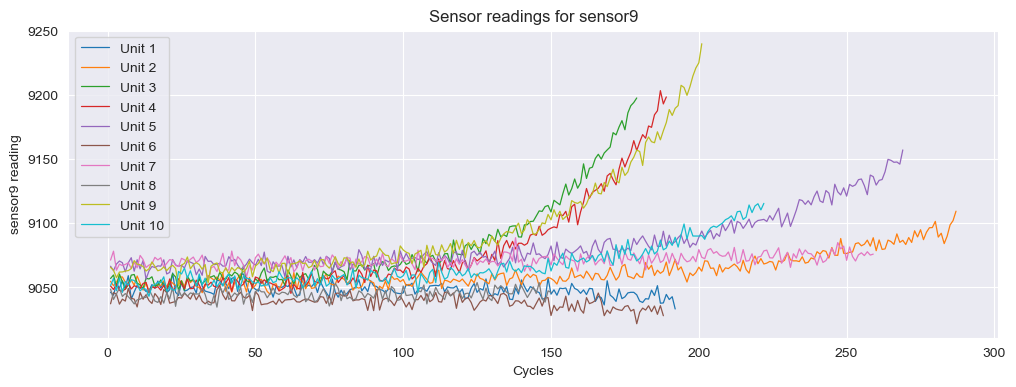

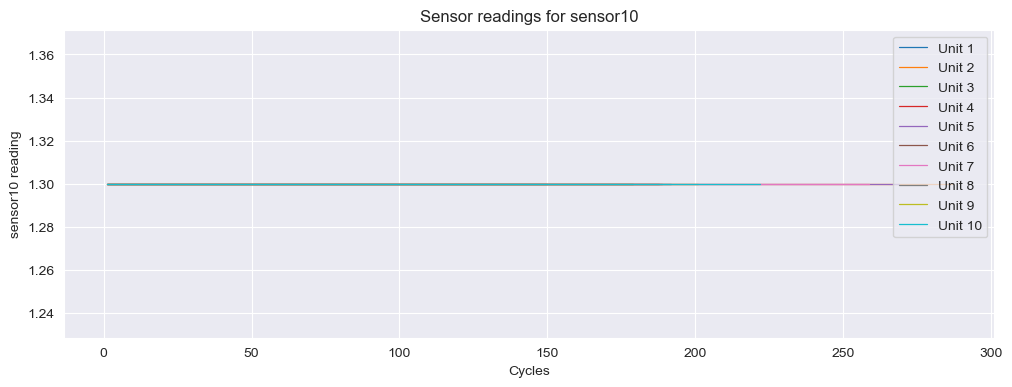

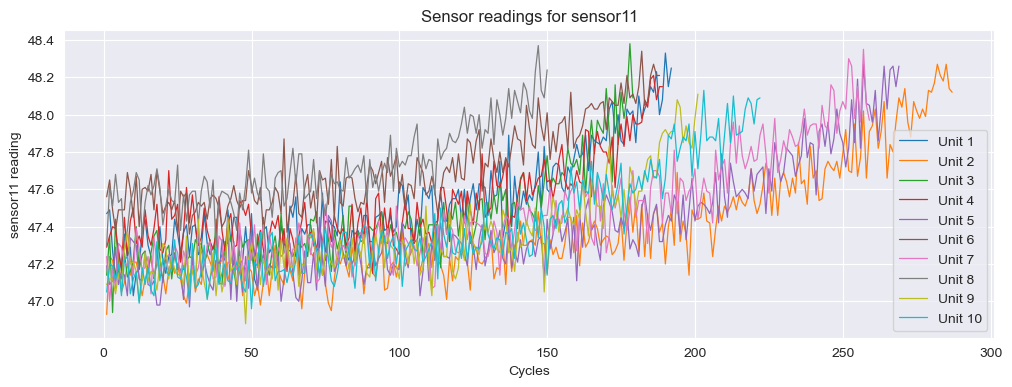

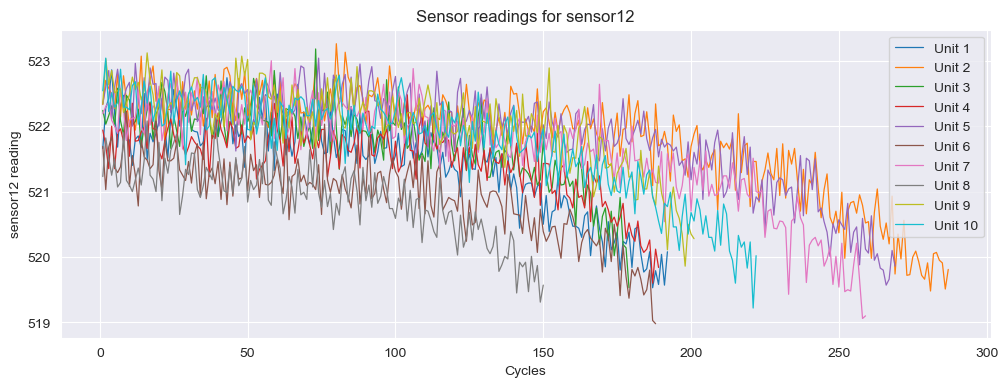

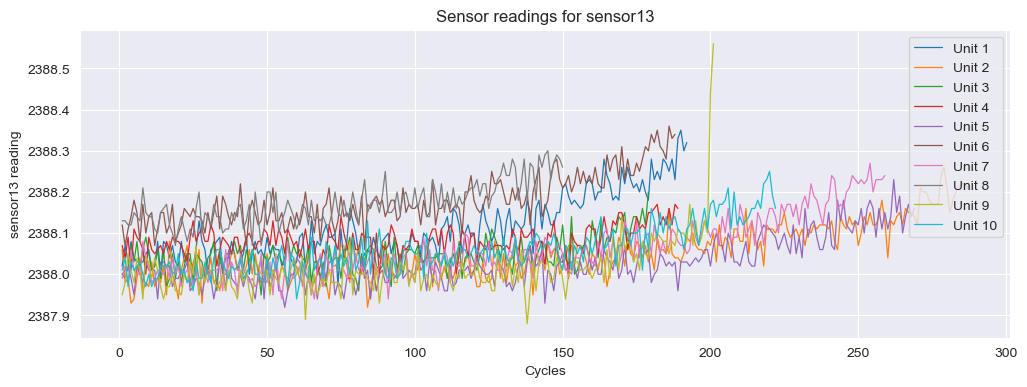

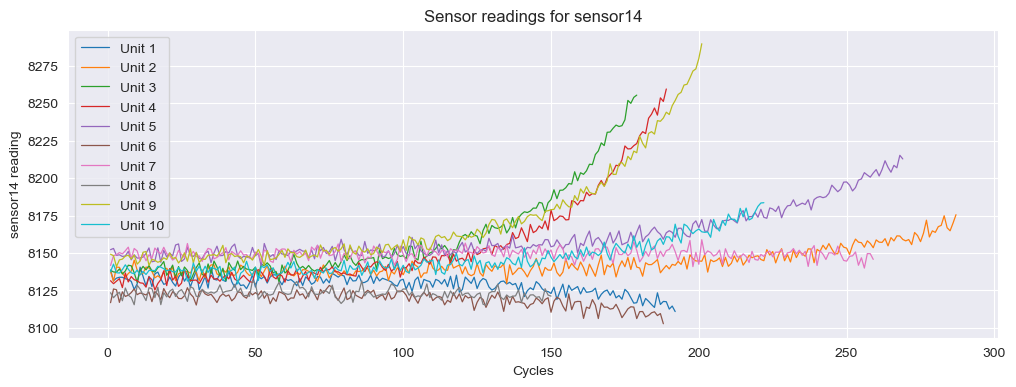

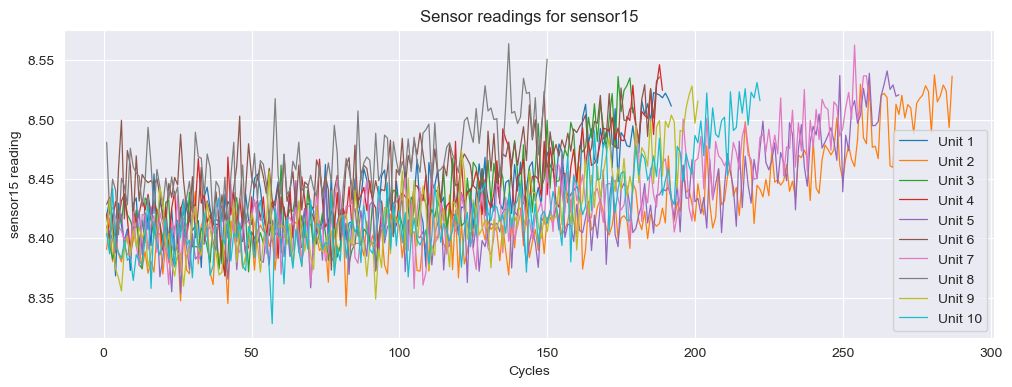

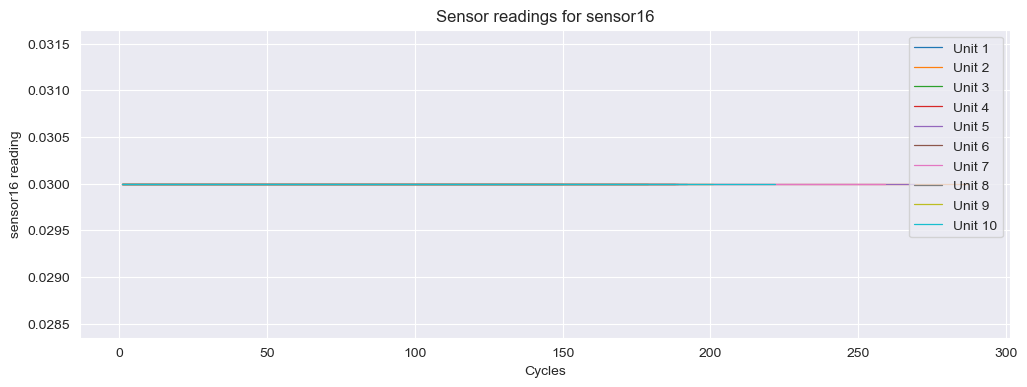

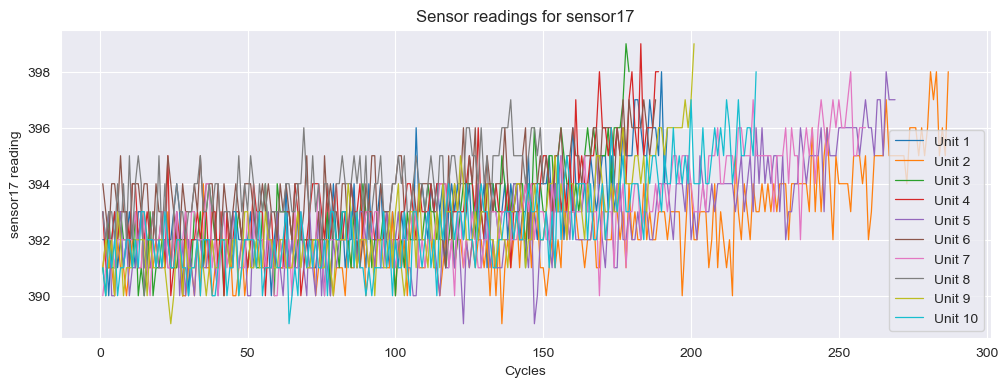

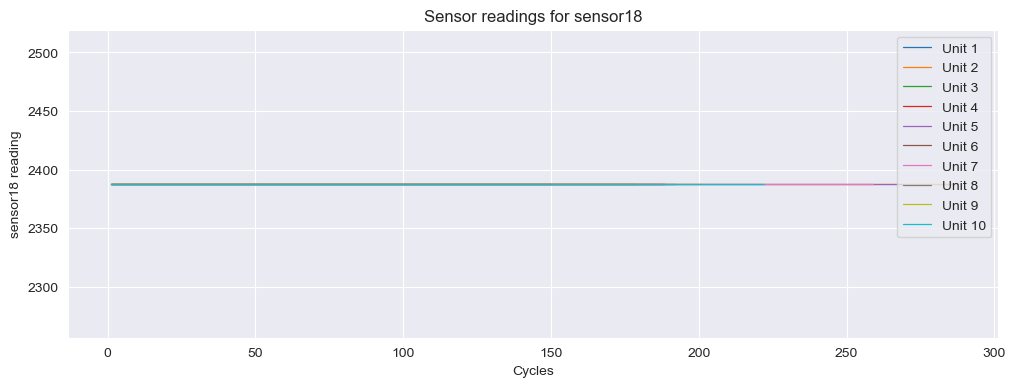

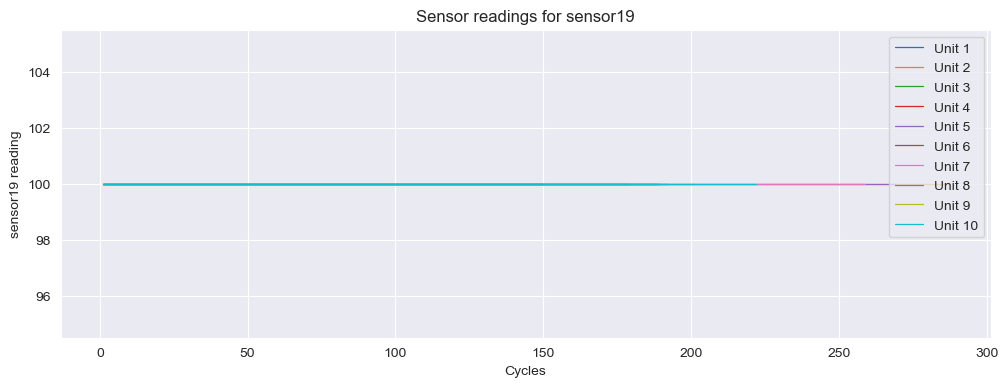

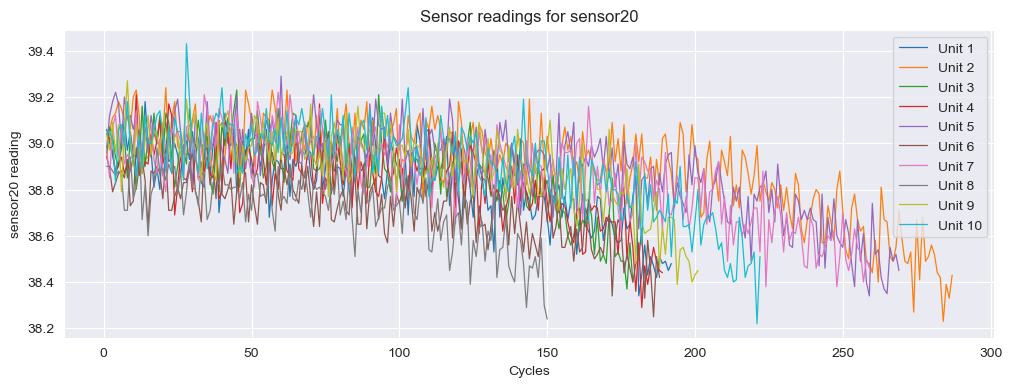

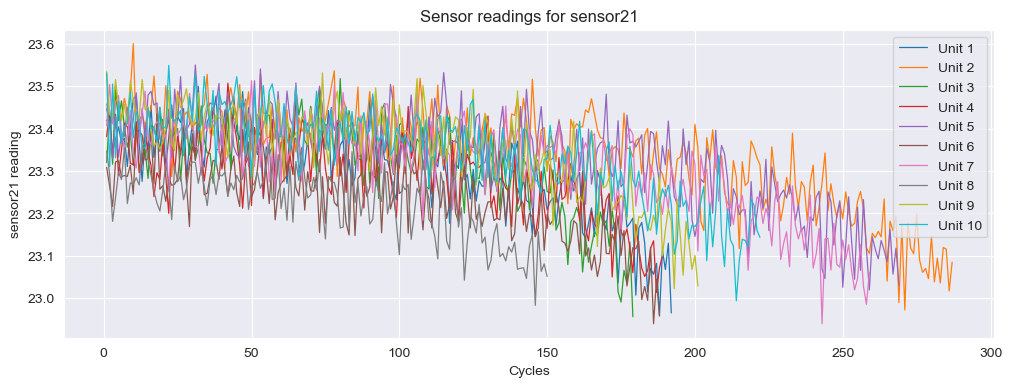

In [15]:
plot_sensor_reading(train_data[0])

In [16]:
# Trajectories FD001 and FD003 both have redundant readings which can be dropped as they are constant or rarely change. FD004 and FD002 both have a redundant sensor 16.
cols_to_drop = ['opMode3', 'sensor1', 'sensor5',
                'sensor6', 'sensor10', 'sensor16',
                'sensor18', 'sensor19', 'sensor17']

train_data[0].drop(columns=cols_to_drop, inplace=True)
train_data[2].drop(columns=cols_to_drop, inplace=True)
test_data[0].drop(columns=cols_to_drop, inplace=True)
test_data[2].drop(columns=cols_to_drop, inplace=True)

train_data[1].drop(columns=['sensor16'], inplace=True)
train_data[3].drop(columns=['sensor16'], inplace=True)


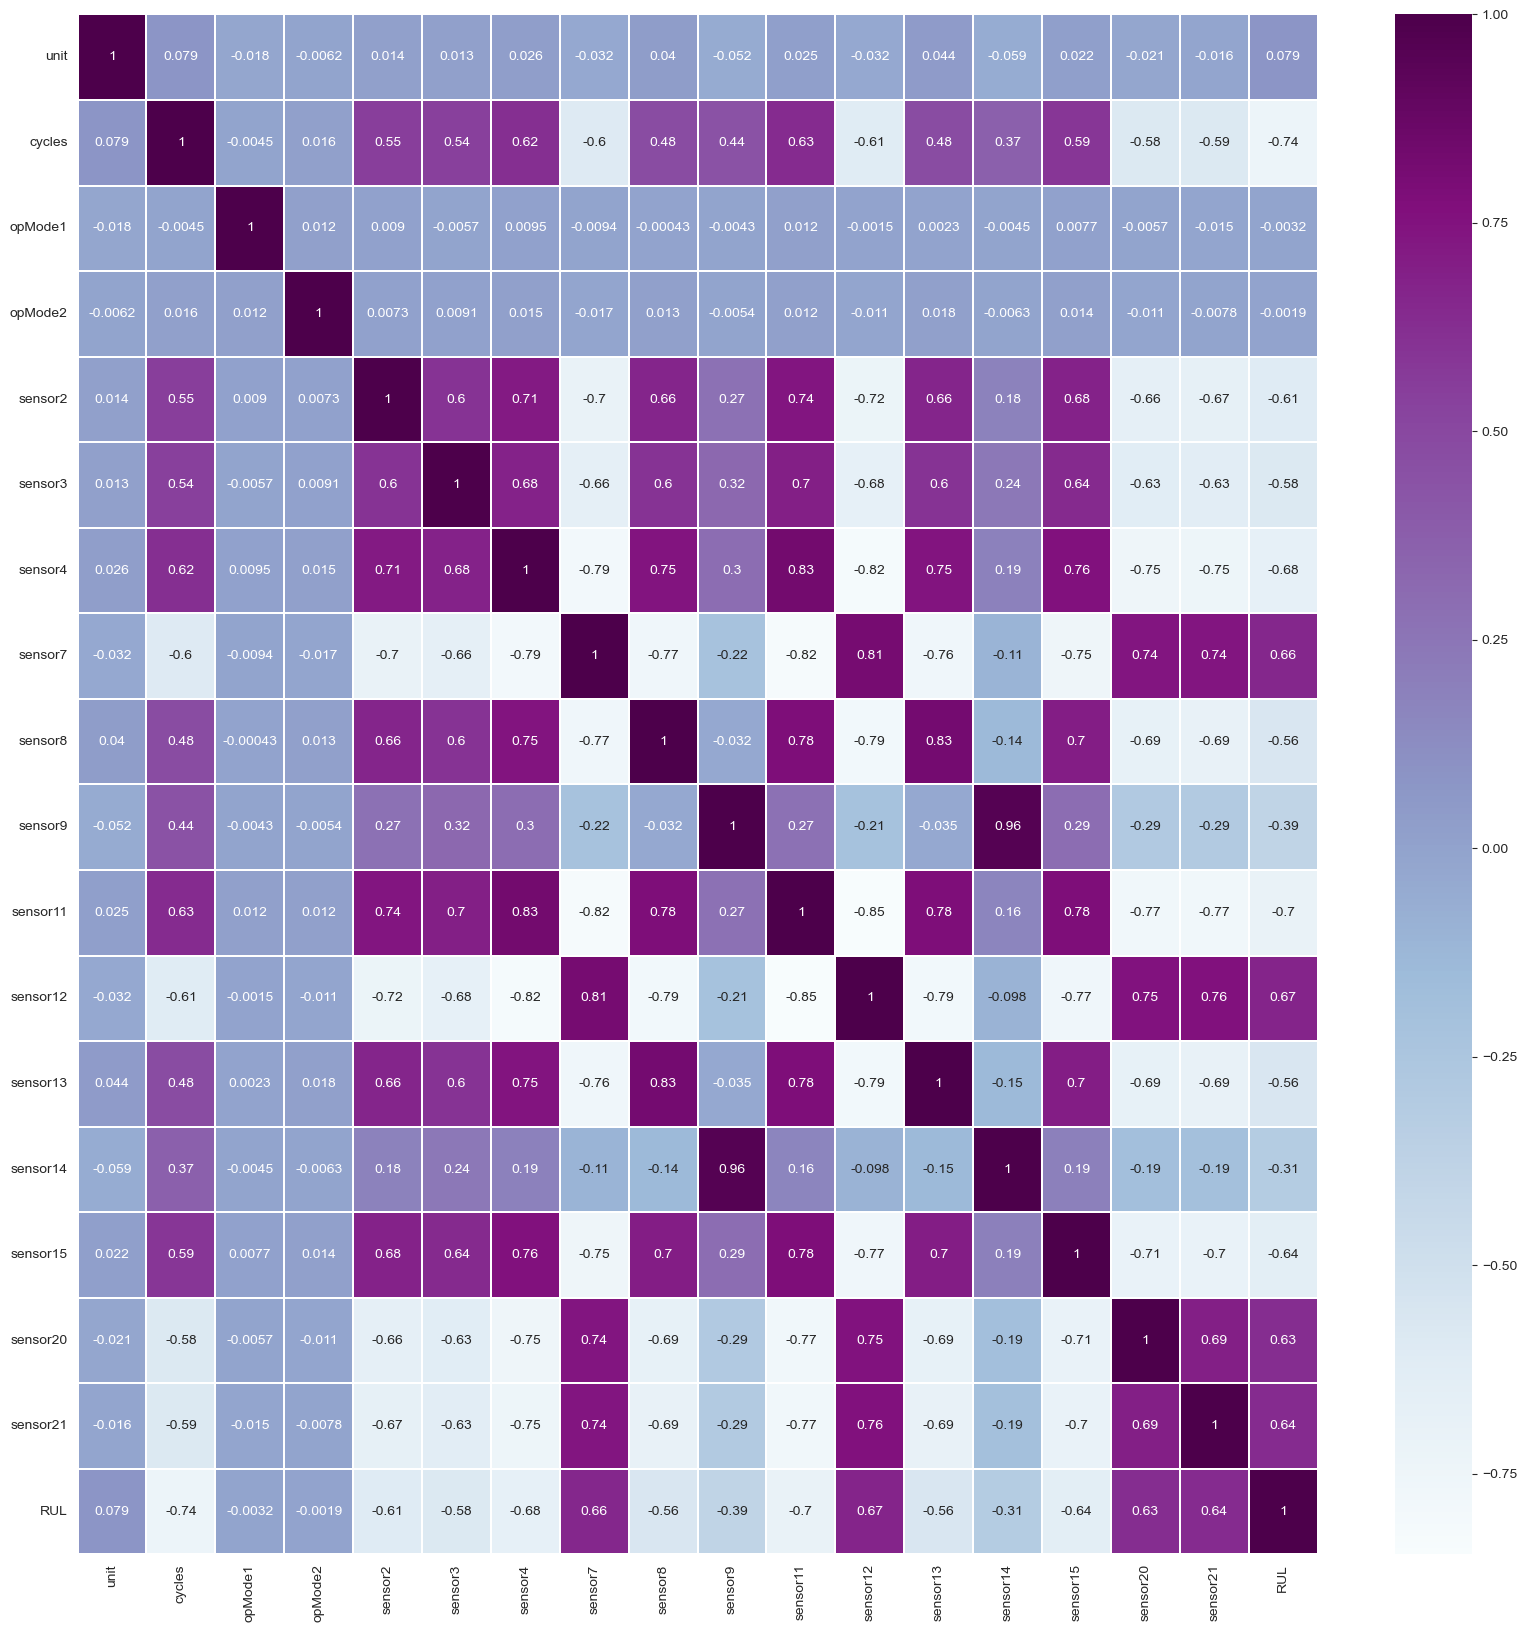

In [17]:
sns.heatmap(train_data[0].corr(), annot=True, cmap='BuPu', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()

In [18]:
# Removing properties with weak correlation and high inter-correlation
# sensor 14 and has aa very high correlation with sensor 9, we can remove sensor 14 to reduce multicollinearity
train_data[0].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
test_data[0].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
train_data[2].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
test_data[2].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)

In [19]:
# Min-max scaling the data, except [unit, cycles, RUL]
scaler = MinMaxScaler(feature_range=(-1, 1))

train_data[0].iloc[:, 2:-1] = scaler.fit_transform(train_data[0].iloc[:, 2:-1])
test_data[0].iloc[:, 2:] = scaler.transform(test_data[0].iloc[:, 2:])

train_data[2].iloc[:, 2:-1] = scaler.fit_transform(train_data[2].iloc[:, 2:-1])
test_data[2].iloc[:, 2:] = scaler.transform(test_data[2].iloc[:, 2:])


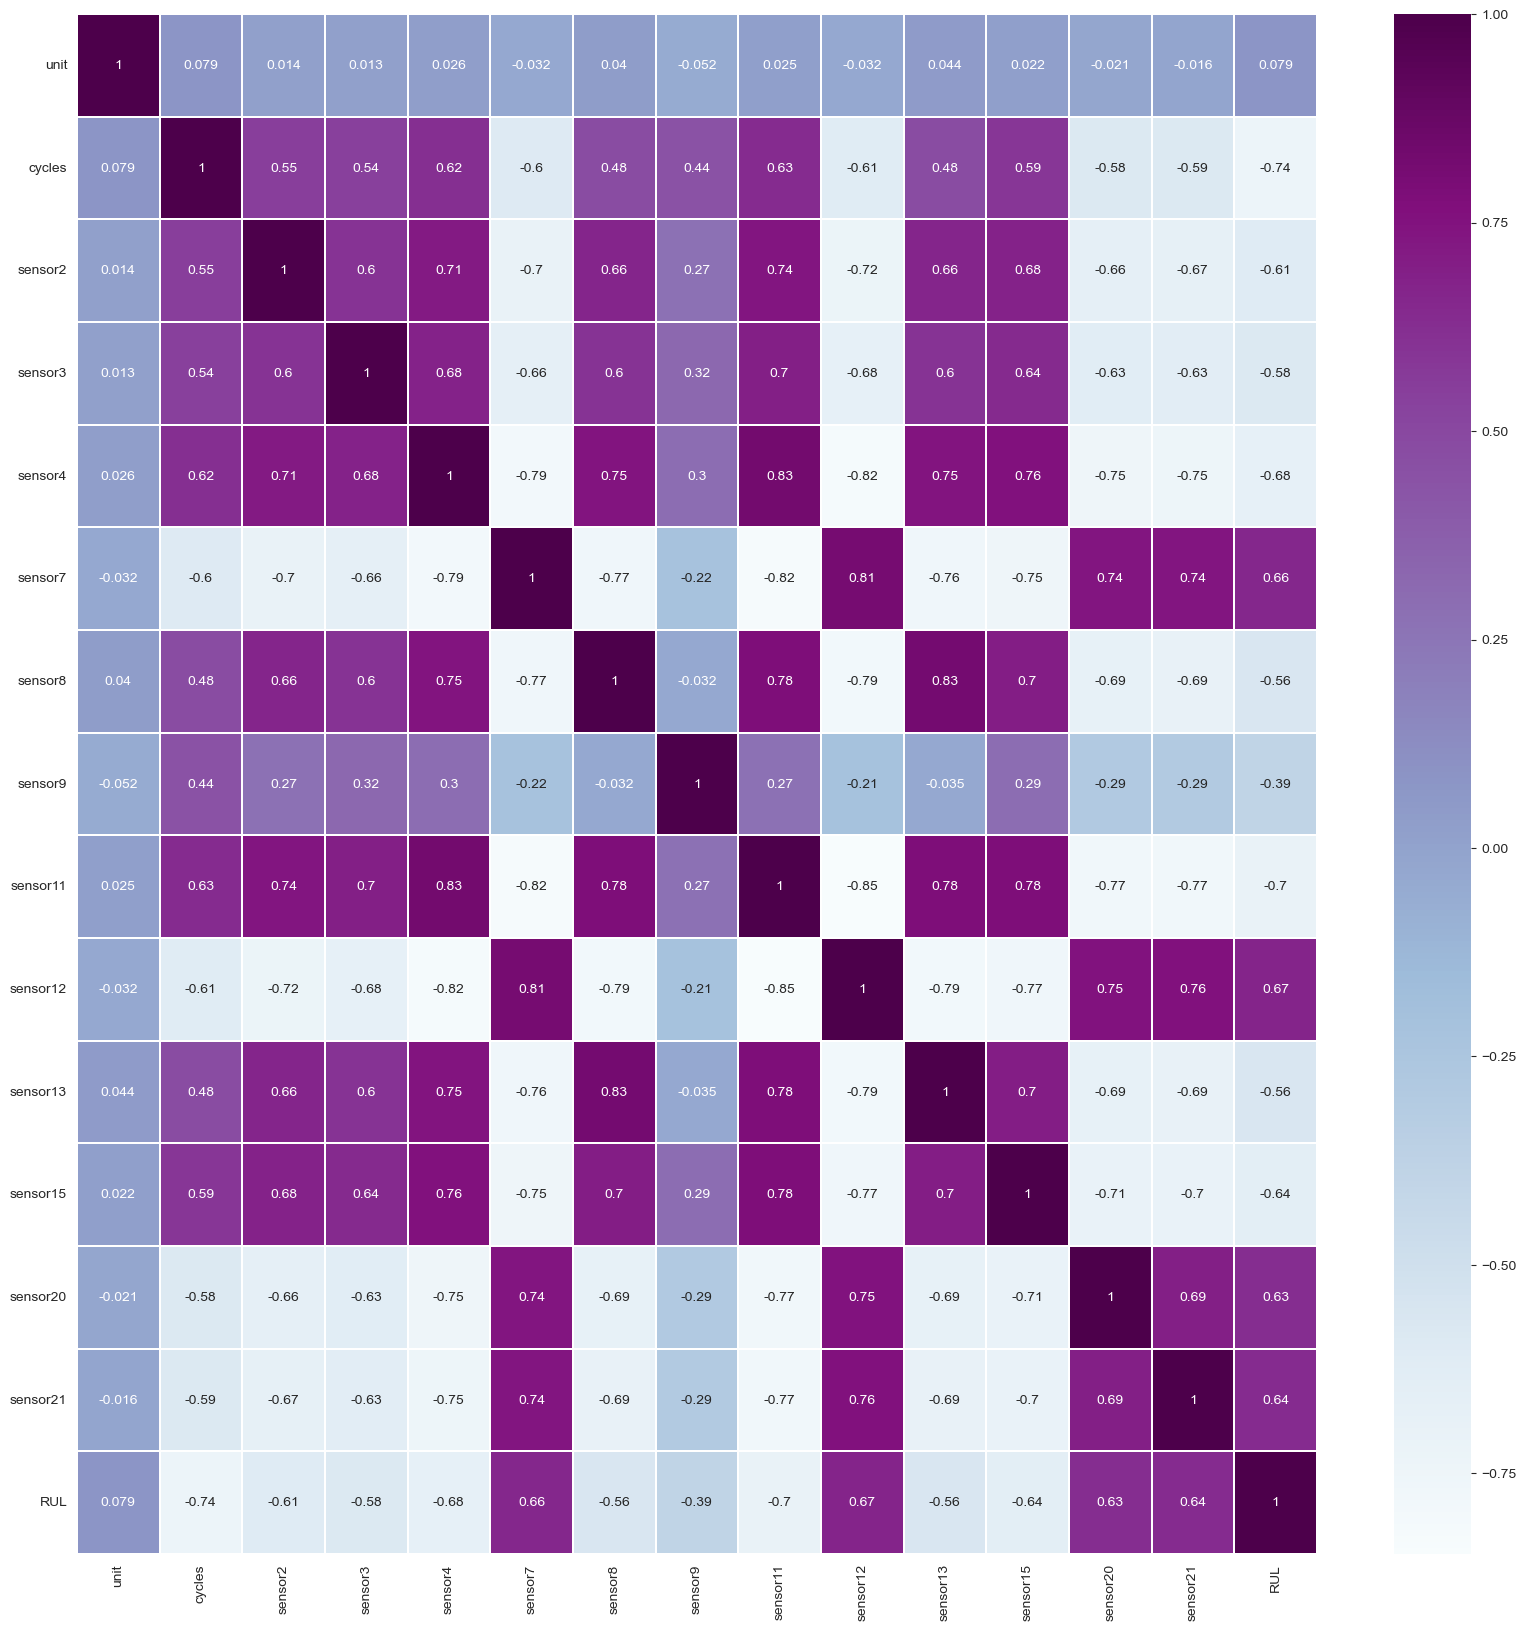

In [20]:
sns.heatmap(train_data[0].corr(), annot=True, cmap='BuPu', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()

The data is extremely noisy. Here we apply a Savitzky-Golay filter to retain the trend and shape while smoothing out any noise with a window length equal to the number of cycles any given unit has lasted for.

In [21]:
from scipy.signal import savgol_filter as svg

In [22]:
# applying Savitzky-Golay to all sensor readings
def filter_readings(df):
    temp = df.copy(deep=True)
    for i in df['unit'].unique():
        mask = df['unit'] == i
        masked = df[mask]
        if 'RUL' in masked.columns:
            for header, column in masked.drop(['unit', 'cycles', 'RUL'], axis=1).items():
                temp.loc[mask, header] = svg(column, window_length=len(column), polyorder=2)
        else:
            for header, column in masked.drop(['unit', 'cycles'], axis=1).items():
                temp.loc[mask, header] = svg(column, window_length=len(column), polyorder=2)
    return temp


In [23]:
filter_testing = filter_readings(train_data[0])

In [24]:
for i in range(1, 50):
    plt.plot(filter_testing[filter_testing['unit'] == i].reset_index()['sensor4'])
plt.title('Savitzky-Golay filter')
plt.xlabel('RUL')
plt.ylabel('Sensor reading')
plt.show()

In [25]:
# Final look at array
train_data[0]

unit  cycles   sensor2   sensor3   sensor4   sensor7   sensor8  \
0         1       1 -0.632530 -0.186396 -0.380486  0.452496 -0.515152   
1         1       2 -0.433735 -0.093961 -0.294733  0.256039 -0.575758   
2         1       3 -0.313253 -0.260955 -0.258947  0.420290 -0.454545   
3         1       4 -0.313253 -0.487683 -0.337610  0.481481 -0.363636   
4         1       5 -0.301205 -0.485066 -0.190749  0.336554 -0.515152   
...     ...     ...       ...       ...       ...       ...       ...   
20626   100     196  0.373494  0.174624  0.565834 -0.491143 -0.121212   
20627   100     197  0.403614  0.458906  0.732951 -0.674718  0.000000   
20628   100     198  0.331325  0.369959  0.550641 -0.648953  0.030303   
20629   100     199  0.216867  0.492043  0.494936 -0.732689  0.060606   
20630   100     200  0.590361  0.279267  0.684335 -0.697262  0.090909   

        sensor9  sensor11  sensor12      sensor13  sensor15  sensor20  \
0     -0.780490 -0.261905  0.266525 -5.882353e-01 -0.272028  0.426357   
1     -0.799515 -0.238095  0.530917 -4.411765e-01 -0.177376  0.333333   
2     -0.719914 -0.500000  0.590618 -5.588235e-01 -0.285110  0.255814   
3     -0.750965 -0.666667  0.778252 -4.117647e-01 -0.666795  0.147287   
4     -0.700081 -0.488095  0.492537 -5.294118e-01 -0.195845  0.178295   
...         ...       ...       ...           ...       ...       ...   
20626 -0.607018  0.452381 -0.658849  1.176471e-01  0.313582 -0.457364   
20627 -0.610697  0.416667 -0.577825 -9.094947e-13  0.454406 -0.751938   
20628 -0.603608  0.476190 -0.437100  5.882353e-02  0.844556 -0.534884   
20629 -0.533429  0.833333 -0.582090  2.941176e-02  0.646787 -0.767442   
20630 -0.643274  0.607143 -0.739872  1.176471e-01  0.375144 -0.643411   

       sensor21  RUL  
0      0.449323  191  
1      0.462027  190  
2      0.242751  189  
3      0.324772  188  
4      0.409003  187  
...         ...  ...  
20626 -0.781000    4  
20627 -0.267606    3  
20628 -0.892019    2  
20629 -0.531069    1  
20630 -0.563656    0  

[20631 rows x 15 columns]

In [29]:
# Creating a training sequence
def create_training_sequence(df, seq_length, seq_cols):
    
    """function to prepare training data into (samples, time steps, features)
    df = training dataframe
    seq_length = look-back period
    seq_cols = feature columns"""

    data_array = df[seq_cols].values
    num_elements = data_array.shape[0]

    lstm_array = []

    for start, stop in zip(range(0, num_elements - seq_length + 1), range(seq_length, num_elements + 1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

def create_target_sequence(df, seq_length, label):
    data_array = df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length - 1:num_elements + 1]


def create_training_batch(df, seq_length, columns):
    """Since the test data is stopped some arbitrary time before failure,
       the number of engine cycles won't necessarily be longer than a given window length,
       so we generate testing sequences which meet the sequence_length 
       """
    x = np.concatenate(
        list(list(create_training_sequence(df[df['unit'] == i], seq_length, columns)) for i in df['unit'].unique()))
    y = np.concatenate(
        list(list(create_target_sequence(df[df['unit'] == i], seq_length, 'RUL')) for i in df['unit'].unique()))
    return x, y


In [30]:
FD_columns = [[column for column in df if column != 'RUL'] for df in train_data]

In [31]:
sequence_length = 10
trajectory = 0  # see readme file
batch_size = 128

In [32]:
FD001_train = filter_readings(train_data[trajectory])
FD001_test = filter_readings(test_data[trajectory])
FD001_truth = RUL_data[trajectory]

In [33]:
a, b = create_training_batch(FD001_train, sequence_length, FD_columns[trajectory])

In [34]:
feature_count = a.shape[2]  # feature count for CNN compatibility
out_dim = 1  # output dimension (1 RUL value)

In [67]:
x_train, x_val, y_train, y_val = train_test_split(a, b, test_size=0.4, random_state=42)

In [68]:
# Using the ground truth labels to create an RUL column in the test data
rul = pd.DataFrame(FD001_test.groupby('unit')['cycles'].max()).reset_index()
rul.columns = ['unit', 'max']
FD001_truth.columns = ['rulTruth']
FD001_truth['unit'] = np.arange(1, len(rul) + 1, 1)  # 100 units
FD001_truth['startLife'] = rul['max'] + FD001_truth['rulTruth']  # 
FD001_truth.drop(columns=['rulTruth'], inplace=True)

ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements

In [69]:
FD001_test = FD001_test.merge(FD001_truth, on=['unit'], how='left')
FD001_test['RUL'] = FD001_test['startLife'] - FD001_test['cycles']
FD001_test.drop('startLife', axis=1, inplace=True)

In [70]:
test_cols = list(FD001_test.columns[:-1])
x_test = create_training_sequence(FD001_test, sequence_length, test_cols)

# Model performance functions


# Random forest regressor

In [71]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=90, n_jobs=-1, max_features=13, max_depth=10, random_state=42)

# Reshaping 3D tensors for random forest compatibility
x_train_reshaped = x_train.reshape(x_train.shape[0], sequence_length * feature_count)
x_val_reshaped = x_val.reshape(x_val.shape[0], sequence_length * feature_count)
x_test_reshaped = x_test.reshape(x_test.shape[0], sequence_length * feature_count)
start_idx = 2000
end_idx = 2900

truncated_ground_truth = FD001_test['RUL'][(sequence_length-1):].reset_index(drop=True)
truncated_subset = truncated_ground_truth[start_idx:end_idx].reset_index(drop=True)

rf.fit(x_train_reshaped, y_train)

rf_val_predictions = rf.predict(x_val_reshaped)
rf_test_predictions = rf.predict(x_test_reshaped)

In [72]:
from sklearn.svm import SVR
svr_regressor = SVR(kernel='rbf')
svr_regressor.fit(x_train_reshaped, y_train) 

SVR()

In [73]:
y_svr_train = svr_regressor.predict(x_train_reshaped)
y_svr_test = svr_regressor.predict(x_test_reshaped)
y_svr_val = svr_regressor.predict(x_val_reshaped)

In [78]:
# Calculating the s-score metric
def s_score(y_true, y_pred, a1, a2):
    n = len(y_true)
    d = y_true - y_pred
    d = d.apply(lambda x: np.exp(-1 * (x / a1) - 1) if x < 0 else np.exp(x / a2) - 1)
    d = d.sum()
    return d 

In [79]:
a1 = 10
a2 = 13

In [80]:
def evaluation_metrics(ground_truth, prediction, a1=10, a2=13, model=None):
    print("Evaluation metrics for ", model)
    print(f"Mean squared error: {mean_squared_error(ground_truth, prediction)}")
    print(f"Root mean squared error: {root_mean_squared_error(ground_truth, prediction)}")
    print(f"R2 score: {r2_score(ground_truth, prediction)}")
    print(f"Mean absolute error: {mean_absolute_error(ground_truth, prediction)}")
    print(f"S-score: {s_score(ground_truth, prediction, a1, a2)}")
    return None

# Automatic model selection
We can use libraries like FLAML to automatically select and optimise the hyperparameters of methods like LightGBM or XGBoost.

In [81]:
from flaml import AutoML

In [82]:
automl = AutoML()
automl.fit(x_train_reshaped, y_train, task='regression', time_budget=120, metric='mse')

[flaml.automl.logger: 08-16 20:21:39] {1680} INFO - task = regression
[flaml.automl.logger: 08-16 20:21:39] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 08-16 20:21:39] {1789} INFO - Minimizing error metric: mse
[flaml.automl.logger: 08-16 20:21:39] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 08-16 20:21:39] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 08-16 20:21:39] {2345} INFO - Estimated sufficient time budget=1493s. Estimated necessary time budget=11s.
[flaml.automl.logger: 08-16 20:21:39] {2392} INFO -  at 0.2s,	estimator lgbm's best error=2676.4298,	best estimator lgbm's best error=2676.4298
[flaml.automl.logger: 08-16 20:21:39] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 08-16 20:21:40] {2392} INFO -  at 0.3s,	estimator lgbm's best error=2676.4298,	best estimator lgbm's best error=2676.4298
[flaml.automl.logger: 08-16 20:21:40

In [84]:
automl_pred = automl.predict(x_test_reshaped)

In [88]:
evaluation_metrics(truncated_ground_truth, rf_test_predictions, a1, a2, 'Random forest')
print("----------")
evaluation_metrics(truncated_ground_truth, y_svr_test, a1, a2, 'SVR')
print("----------")
evaluation_metrics(truncated_ground_truth, automl_pred, a1, a2, 'AutoML')
print("----------")


Evaluation metrics for  Random forest
Mean squared error: 1997.7684442486097
Root mean squared error: 44.69640303479252
R2 score: 0.42605535969498065
Mean absolute error: 33.43338291083266
S-score: 309864081.75212806
----------
Evaluation metrics for  SVR
Mean squared error: 2772.674412348665
Root mean squared error: 52.656190636511724
R2 score: 0.20343039612034708
Mean absolute error: 39.04848251804389
S-score: 797293294.4885414
----------
Evaluation metrics for  AutoML
Mean squared error: 2065.678119738748
Root mean squared error: 45.449731789513876
R2 score: 0.4065453937704374
Mean absolute error: 34.0585384831484
S-score: 506584169.7592986
----------


In [ ]:
# The deep learning model seems to be able to capture the dependencies better than regressors can, with a higher R2 score and lower s-score.